In [1]:
from datetime import datetime

import cudf as cd
import cupy as cp
import numpy as np
import pandas as pd
from tqdm import tqdm

CUDF = False
print(f"Using {'cuDF' if CUDF else 'Pandas'}")


COUNT = 1_000_000
PREVALENCE = 0.10
NUM_NODES = 768

INC_MEAN = np.float32(7.0)
INC_STD = np.float32(1.0)
INF_MEAN = np.float32(7.0)
INF_STD = np.float32(1.0)
R_NAUGHT = 14.0
BETA = R_NAUGHT / INF_MEAN

t0 = datetime.now(tz=None)  # noqa
susceptibility = np.ones(COUNT, dtype=np.uint8)
etimer = np.zeros(COUNT, dtype=np.uint8)
itimer = np.zeros(COUNT, dtype=np.uint8)
nodeid = np.random.randint(0, NUM_NODES, COUNT).astype(np.uint16)

infectious = (np.random.random(COUNT) < PREVALENCE).astype(np.uint8)
itimer[infectious != 0] = np.round(
    np.random.normal(INF_MEAN, INF_STD, infectious.sum())
)
susceptibility[infectious != 0] = 0
t1 = datetime.now(tz=None)  # noqa
# print(f"Elapsed time (initialization): {t1 - t0}")

adata = {
    "nodeid": nodeid,
    "susceptibility": susceptibility,
    "etimer": etimer,
    "itimer": itimer,
    "draw": np.zeros(COUNT, dtype=np.float32),
    "force": np.zeros(COUNT, dtype=np.float32),
    "transmit": np.zeros(COUNT, dtype=bool),
}

ndata = {
    "infected": np.zeros(NUM_NODES, dtype=np.uint32),
    "pops": np.zeros(NUM_NODES, dtype=np.uint32),
    "forces": np.zeros(NUM_NODES, dtype=np.float32),
}

t0 = datetime.now(tz=None)  # noqa
if CUDF:
    adf = cd.DataFrame(adata)
    ndf = cd.DataFrame(ndata)
    xp = cp
else:
    adf = pd.DataFrame(adata)
    ndf = pd.DataFrame(ndata)
    xp = np
t1 = datetime.now(tz=None)  # noqa
# print(f"Elapsed time (dataframe creation): {t1 - t0}")

TICKS = 365

t0 = datetime.now(tz=None)  # noqa
prevalence = xp.zeros((TICKS + 1, NUM_NODES), dtype=xp.uint32)
prevalence[0, :] = xp.asarray((adf.itimer > 0).groupby(adf.nodeid, sort=True).sum())

...

for tick in tqdm(range(TICKS)):
    adf.loc[adf.itimer > 0, "itimer"] = adf.itimer[adf.itimer > 0] - 1
    count = (adf.etimer == 1).sum()
    adf.loc[adf.etimer == 1, "itimer"] = xp.round(
        xp.random.normal(INF_MEAN, INF_STD, count)
    ).astype(xp.uint8)
    adf.loc[adf.etimer > 0, "etimer"] = adf.etimer[adf.etimer > 0] - 1

    infected = xp.asarray((adf.itimer > 0).groupby(adf.nodeid, sort=True).sum())
    ndf.infected = infected
    # ndf.fillna({"infected": 0}, inplace=True)
    ndf.pops = adf.groupby(adf.nodeid).size().astype(np.uint32)
    ndf.forces = (ndf.infected / ndf.pops).astype(np.float32)
    ndf.forces *= BETA

    draw = xp.random.random(COUNT).astype(np.float32)
    force = xp.asarray(ndf.forces)[xp.asarray(adf.nodeid)]
    force *= adf.susceptibility
    transmit = draw < force
    count = transmit.sum()
    adf.loc[transmit, "etimer"] = xp.round(
        xp.random.normal(INC_MEAN, INC_STD, count)
    ).astype(xp.uint8)
    adf.loc[transmit, "susceptibility"] = xp.uint8(0)

    prevalence[tick + 1, :] = infected

    ...

t1 = datetime.now(tz=None)  # noqa
print(f"Elapsed time (simulation): {t1 - t0}")

...
# print(prevalence[:, 0])


Using Pandas


100%|██████████| 365/365 [00:15<00:00, 23.04it/s]

Elapsed time (simulation): 0:00:15.862469


Ellipsis

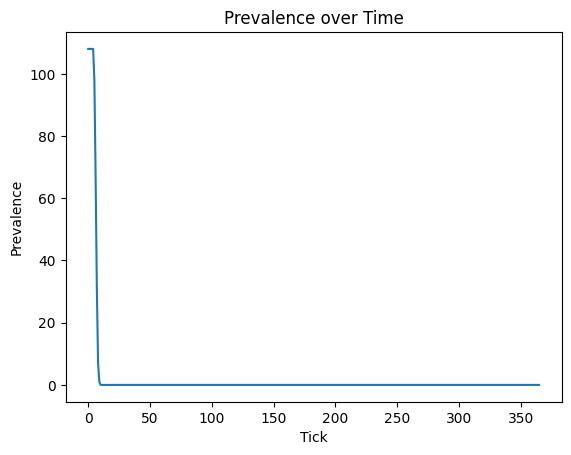

In [37]:
import matplotlib.pyplot as plt

plt.plot((prevalence.get() if CUDF else prevalence)[:, 1])
plt.xlabel('Tick')
plt.ylabel('Prevalence')
plt.title('Prevalence over Time')
plt.show()